<a href="https://colab.research.google.com/github/nataliepham6720/16-745_Optimal_Control/blob/main/LQR_Shooting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial cost: 25.5


<ipython-input-1-d67d8b9e8d02>:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Δu[k] = -(uhist[k] + (1 / R) * B.T @ λhist[:, k + 1])


Final cost: 6.658144576322123
Iterations: 664


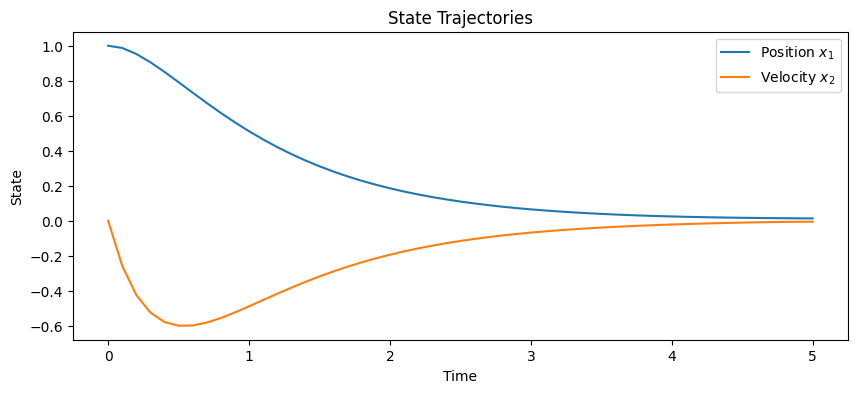

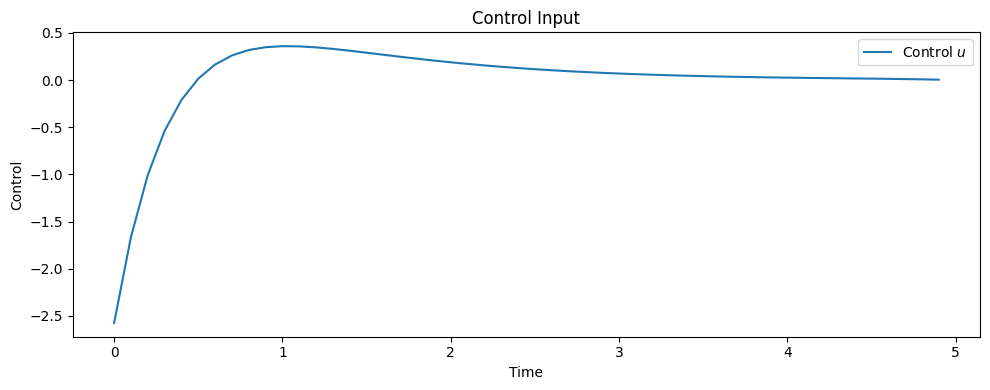

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# System Dynamics
# -----------------------
h = 0.1
A = np.array([[1, h],
              [0, 1]])
B = np.array([[0.5 * h ** 2],
              [h]])

n = 2  # state dimension
m = 1  # control dimension
Tfinal = 5.0  # try larger values if desired
N = int(Tfinal / h) + 1
times = np.linspace(0, h * (N - 1), N)

# -----------------------
# Initial condition
# -----------------------
x0 = np.array([1.0, 0.0])

# -----------------------
# Cost matrices
# -----------------------
Q = np.eye(n)
R = 0.1
Qn = np.eye(n)

# -----------------------
# Cost function
# -----------------------
def J(xhist, uhist):
    cost = 0.5 * xhist[:, -1].T @ Qn @ xhist[:, -1]
    for k in range(N - 1):
        cost += 0.5 * xhist[:, k].T @ Q @ xhist[:, k]
        cost += 0.5 * R * uhist[k] ** 2
    return cost

# -----------------------
# Rollout function
# -----------------------
def rollout(xhist, uhist):
    xnew = np.zeros_like(xhist)
    xnew[:, 0] = xhist[:, 0]
    for k in range(N - 1):
        xnew[:, k + 1] = A @ xnew[:, k] + B.flatten() * uhist[k]
    return xnew

# -----------------------
# Initialization
# -----------------------
xhist = np.tile(x0.reshape(-1, 1), (1, N))
uhist = np.zeros(N - 1)
Δu = np.ones(N - 1)
λhist = np.zeros((n, N))

xhist = rollout(xhist, uhist)

print("Initial cost:", J(xhist, uhist))

# -----------------------
# Optimization loop
# -----------------------
b = 1e-2
α = 1.0
iter_count = 0

while np.max(np.abs(Δu)) > 1e-2:
    # Backward pass
    λhist[:, -1] = Qn @ xhist[:, -1]
    for k in reversed(range(N - 1)):
        Δu[k] = -(uhist[k] + (1 / R) * B.T @ λhist[:, k + 1])
        λhist[:, k] = Q @ xhist[:, k] + A.T @ λhist[:, k + 1]

    # Forward pass with line search
    α = 1.0
    unew = uhist + α * Δu
    xnew = rollout(xhist, unew)

    while J(xnew, unew) > J(xhist, uhist) - b * α * np.dot(Δu, Δu):
        α *= 0.5
        unew = uhist + α * Δu
        xnew = rollout(xhist, unew)

    uhist = unew
    xhist = xnew
    iter_count += 1

print("Final cost:", J(xhist, uhist))
print("Iterations:", iter_count)

# -----------------------
# Plotting
# -----------------------
plt.figure(figsize=(10, 4))
plt.plot(times, xhist[0, :], label="Position $x_1$")
plt.plot(times, xhist[1, :], label="Velocity $x_2$")
plt.xlabel("Time")
plt.ylabel("State")
plt.legend()
plt.title("State Trajectories")

plt.figure(figsize=(10, 4))
plt.plot(times[:-1], uhist, label="Control $u$")
plt.xlabel("Time")
plt.ylabel("Control")
plt.legend()
plt.title("Control Input")

plt.tight_layout()
plt.show()
